In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pl_temp_fit import (
    Exp_data_utils,
    config_utils,
    fit_pl_utils,
    generate_data_utils,
)

os.chdir("/media/mohammed/Work/Work/pl_temp_fit/")
# access the right directory
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
databse_path = Path("fit_experimental_emcee_pl/fit_data_base/")
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for _id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )
    if os.path.exists(model_config_save["save_folder"] + "/sampler.h5"):
        filename = model_config_save["save_folder"] + "/sampler.h5"
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            if not reader.initialized:
                print("multi_core empty file")
                continue
            if reader.iteration == 0:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)
        except AttributeError:
            print("check if single core")

            reader = emcee.backends.HDFBackend(filename, name="single_core")
            if not reader.initialized:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)

        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)

        list_model_config.append(model_config_save)
if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,/media/mohammed/Work/Work/pl_temp_fit/experiem...,888,-30.609546
1,/media/mohammed/Work/Work/pl_temp_fit/experiem...,548,-279.561542
2,/media/mohammed/Work/Work/pl_temp_fit/experiem...,3000,-140.505321


In [3]:
index_analyse = 1
test_id = df_all["test_id"].loc[index_analyse]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=databse_path
)
filename = model_config_save["save_folder"] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

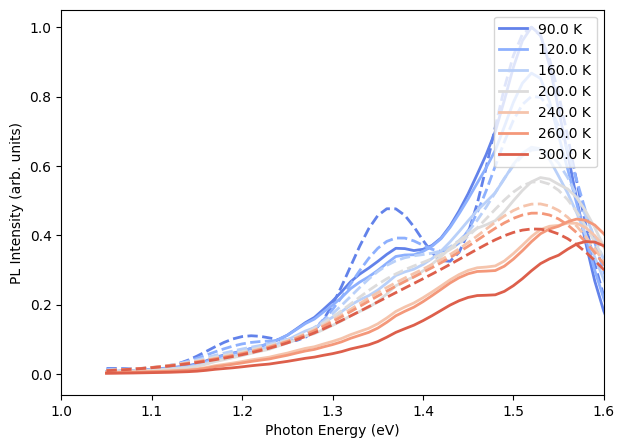

In [4]:
def plot_pl_data(
    truemodel_pl,
    temperature_list,
    hws,
    title="Experimental Data",
    fixed_parameters_dict=None,
    true_parameters=None,
):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    data_true_plot = truemodel_pl.reshape(len(hws), -1) / max(
        truemodel_pl.reshape(-1, 1)
    )
    import seaborn as sns

    model_data_pl, EX_kr, Ex_knr = generate_data_utils.pl_trial(
        temperature_list,
        hws,
        fixed_parameters_dict,
        true_parameters,
    )

    color_list = sns.color_palette("coolwarm", len(temperature_list))
    model_data_pl = model_data_pl / np.max(model_data_pl)
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            data_true_plot[:, i],
            label="" + str(temperature_list[i]) + " K",
            color=color_list[i],
            linewidth=2,
        )
        ax.plot(
            hws,
            model_data_pl[:, i],
            linestyle="--",
            color=color_list[i],
            linewidth=2,
            label="",
        )
    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel("PL Intensity (arb. units)")

    return fig, ax


csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
params_to_fit_init = model_config_save["params_to_fit_init"]
true_parameters = fit_pl_utils.get_param_dict(
    params_to_fit_init, distribution[-1]
)
fig, ax = plot_pl_data(
    Exp_data,
    temperature_list,
    hws,
    title="Experimental Data",
    fixed_parameters_dict=fixed_parameters_dict,
    true_parameters=true_parameters,
)
ax.set_xlim(1, 1.6)
# add colorbar to the plot
ax.legend(loc="upper right", fontsize=10)

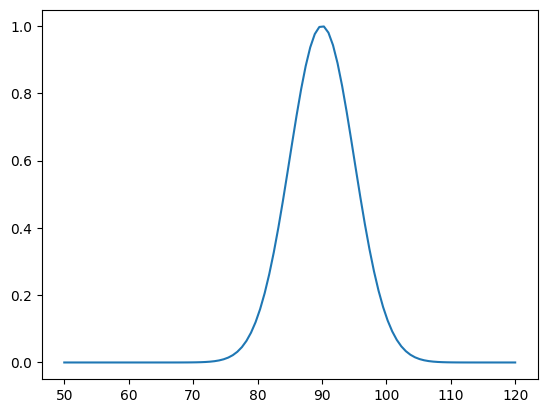

In [5]:
temperature_list_pl = temperature_list
Temp_std_err = 5


# plot gaussian distribution
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))


x = np.linspace(50, 120, 100)
y = gaussian(x, temperature_list[0], Temp_std_err)
plt.plot(x, y)


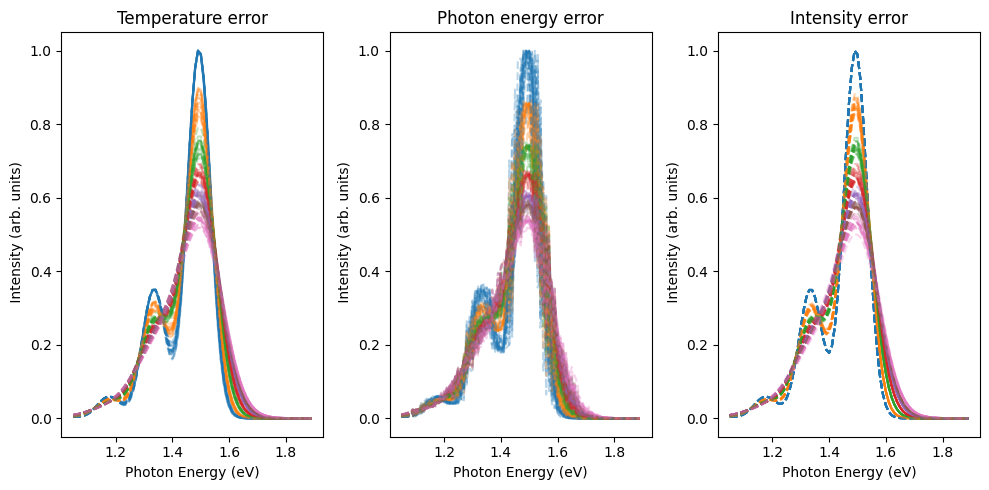

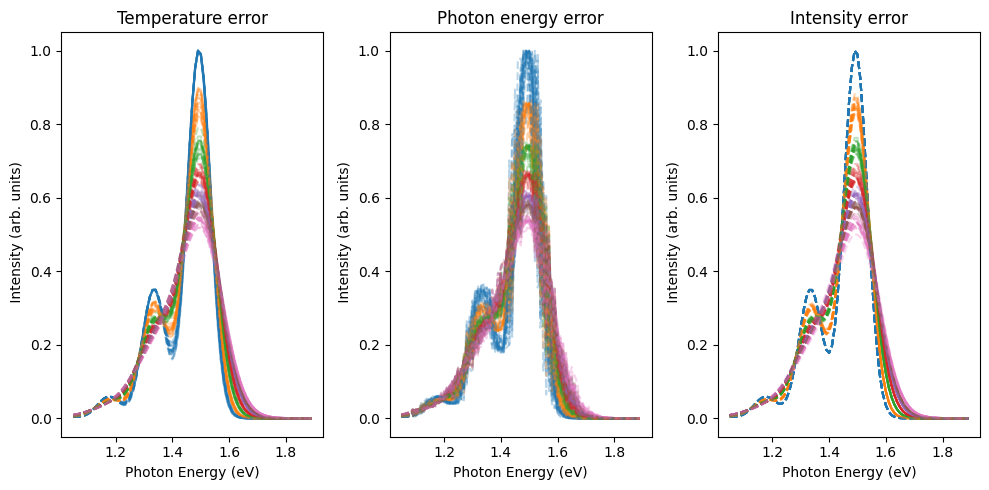

In [6]:
def add_data_list(true_model_list, model_data, hws, temperature_list):
    data_true_plot = model_data.reshape(len(hws), -1)
    data_true_plot = data_true_plot / max(data_true_plot.reshape(-1, 1))
    true_model_list.append(
        data_true_plot.reshape(len(hws), len(temperature_list))
        + np.random.normal(0, 0.01, size=(len(hws), len(temperature_list)))
    )
    return true_model_list


def add_plot_to_ax(hws, temperature_list, ax, model_data):
    data_true_plot = model_data.reshape(len(hws), -1)
    data_true_plot = data_true_plot / max(data_true_plot.reshape(-1, 1))
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            data_true_plot[:, i],
            label="true" + str(temperature_list[i]) + " K",
            linestyle="--",
            color="C" + str(i),
            alpha=0.3,
        )
    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel(" Intensity (arb. units)")
    ax.set_title("Posterior mean prediction")


def plot_generated_data_pl(
    model_config,
    params_to_fit={},
    fixed_parameters_dict={},
    numnber_of_samples=20,
):
    """Plot the generated data

    Args:
    ----
        temperature_list_el {np.array} -- temperatures for EL
        hws_el {np.array} -- photon energies for EL
        temperature_list_pl {np.array} -- temperatures for PL
        hws_pl {np.array} -- photon energies for PL
        save_folder {str} -- folder to save the data
        model_config {dict} -- model configuration
        params_to_fit {dict} -- parameters to fit in the model
        fixed_parameters_dict {dict} -- fixed parameters for the model
    Keyword Arguments:
        savefig {bool} -- save the figure (default: {True})
        true_parameters {dict} -- true parameters for the model (default: {None})

    """
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax = ax.flatten()
    true_model_pl_list = []
    true_model_el_list = []
    list_cases = [
        {
            "Temp_std_err": 5,
            "hws_std_err": 0,
            "relative_intensity_std_error_pl": 0,
        },
        {
            "Temp_std_err": 0,
            "hws_std_err": 0.01,
            "relative_intensity_std_error_pl": 0,
        },
        {
            "Temp_std_err": 0,
            "hws_std_err": 0,
            "relative_intensity_std_error_pl": 0.01,
        }
    ]
    for axis_num, case in enumerate(list_cases):
        model_config["Temp_std_err"] = case["Temp_std_err"]
        model_config["hws_std_err"] = case["hws_std_err"]
        model_config["relative_intensity_std_error_pl"] = case[
            "relative_intensity_std_error_pl"
        ]

        for x in range(numnber_of_samples):
            
            model_data_pl, EX_kr, Ex_knr = generate_data_utils.generate_data_pl(
                **model_config,
                params_to_fit=params_to_fit,
                fixed_parameters_dict=fixed_parameters_dict,
            )
            true_model_pl_list = add_data_list(
                true_model_pl_list,
                model_data_pl,
                model_config["hws_pl"],
                model_config["temperature_list_pl"],
            )
            add_plot_to_ax(
                model_config["hws_pl"],
                model_config["temperature_list_pl"],
                ax[axis_num],
                model_data_pl,
            )

    fig.tight_layout()
    return fig, ax


fig, ax = plot_generated_data_pl(
    model_config,
    params_to_fit=params_to_fit_init,
    fixed_parameters_dict=fixed_parameters_dict,
)
ax[0].set_title("Temperature error")
ax[1].set_title("Photon energy error")
ax[2].set_title("Intensity error")
fig

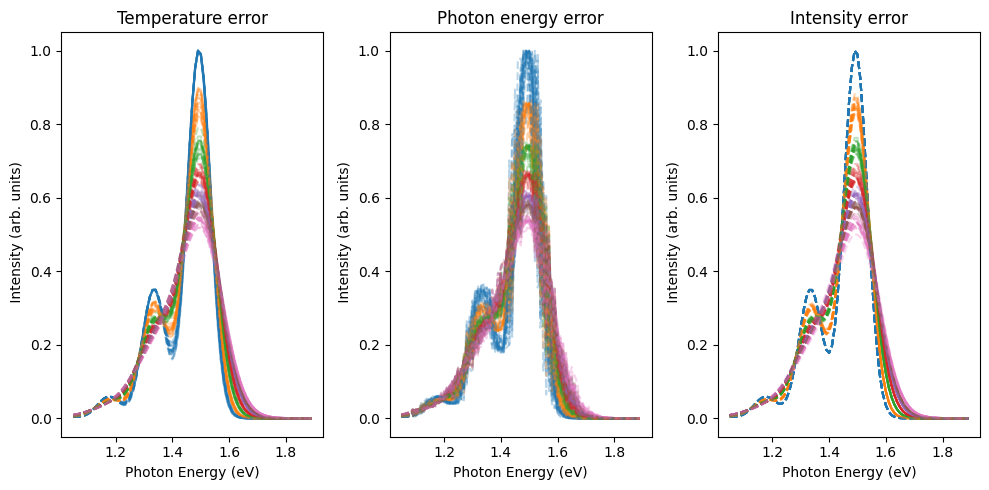

In [7]:
ax[0].set_title("Temperature error")
ax[1].set_title("Photon energy error")
ax[2].set_title("Intensity error")
fig

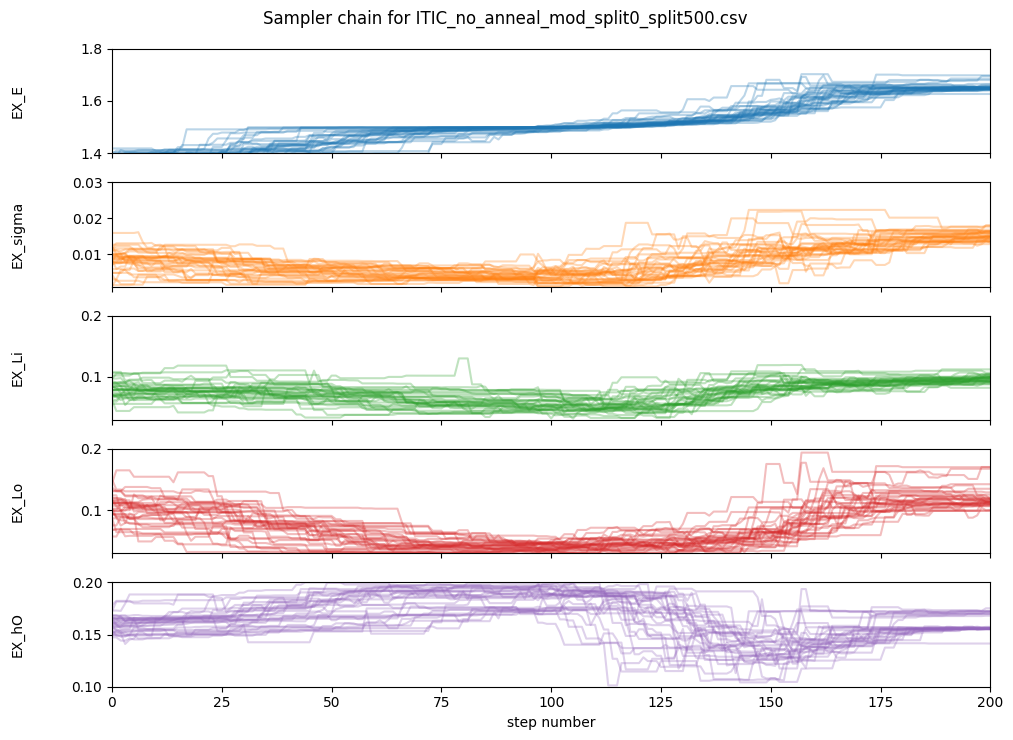

In [8]:
from pl_temp_fit import plot_utils  
fig,ax = plot_utils.plot_chains(reader, model_config_save, discard=0)
for _ax in ax:
    _ax.set_xlim(0, 200)

Text(0.5, 0.98, '')

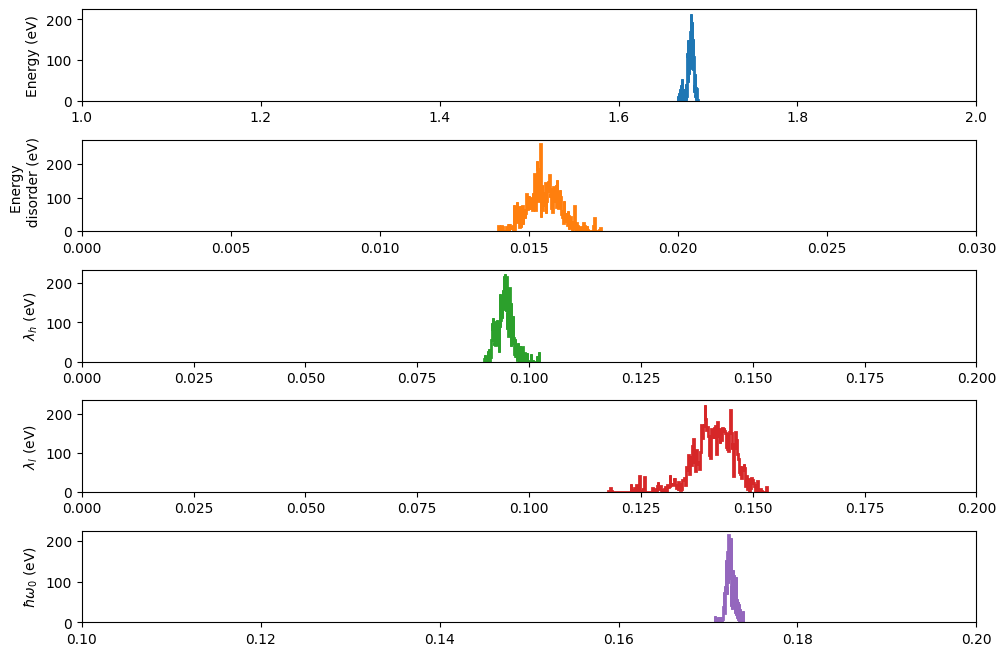

In [26]:
def plot_distribution(
    reader, model_config_save, discard=10, filter_log_likelihood=False,
    fig=None,axes=None
):
    """plot the distribution of the parameters from the sampling output
    reader: the reader object from the emcee sampler
    model_config_save: the model config save dictionary
    discard: the number of samples to discard
    """
    csv_name = model_config_save["csv_name_pl"]
    label_list = []
    for key in model_config_save["params_to_fit_init"].keys():
        label_list.extend(
            [
                key + "_" + x
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
    labels = label_list
    ndim = len(labels)

    distribution = reader.get_chain(discard=discard, flat=True)
    if filter_log_likelihood:
        blobs = reader.get_blobs(flat=True, discard=discard)
        distribution_plot = distribution[
            blobs["log_likelihood"] > max(blobs["log_likelihood"])*1.1
        ]
    if fig is None:
        fig, axes = plt.subplots(5, figsize=(10, 7))
    axes_xlim = [[1, 2], [0, 0.03], [0, 0.2], [0, 0.2], [0.1, 0.2]]
    for i in range(ndim):
        ax = axes[i]
        ax.hist(
            distribution_plot[:, i],
            200,
            color="C" + str(i),
            linewidth=2,
            histtype="step",
            
        )
        ax.set_ylabel(labels[i])
        ax.set_xlim(axes_xlim[i])
    fig.suptitle(f"Sampler distribution for {csv_name.split('/')[-1]}")
    fig.tight_layout()
    return fig, axes

fig,ax = plot_distribution(
    reader, model_config_save, discard=200, filter_log_likelihood=True
)
ax[0].set_ylabel("Energy (eV)")
ax[1].set_ylabel("Energy \n  disorder (eV)")
ax[2].set_ylabel("$\lambda_{h}$ (eV)")
ax[3].set_ylabel("$\lambda_{l}$ (eV)")
ax[4].set_ylabel("$\hbar \omega_{0}$ (eV)")
fig.suptitle("")

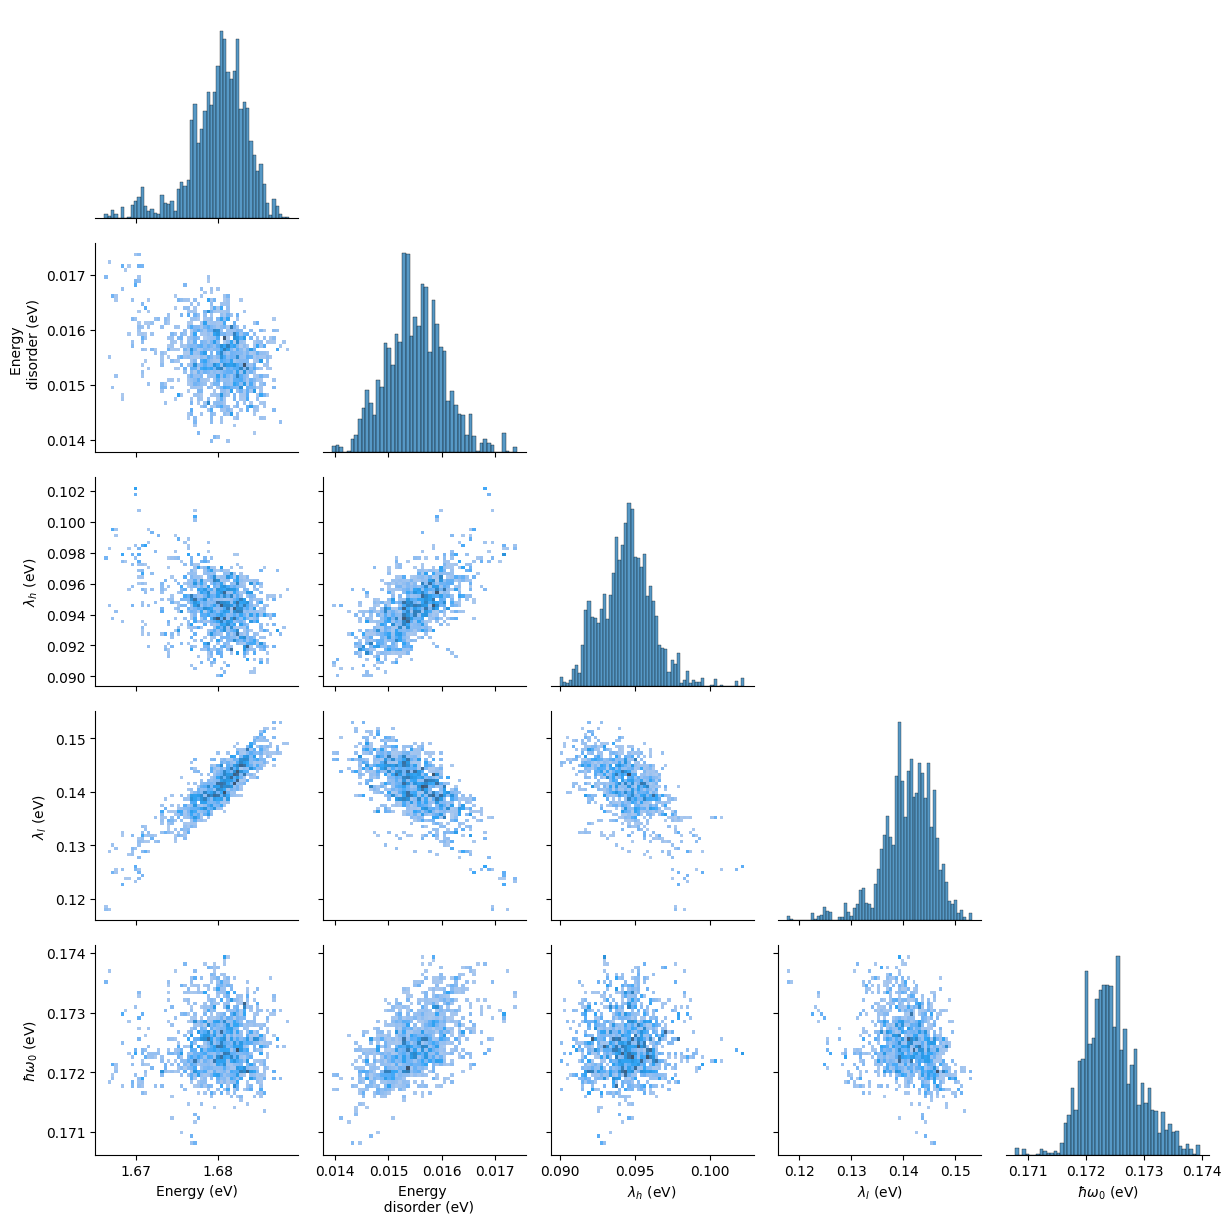

In [23]:
import seaborn as sns

def plot_corner(reader, model_config_save, discard=10,
                filter_log_likelihood=False):
    """plot the corner plot from the sampling output
    reader: the reader object from the emcee sampler
    model_config_save: the model config save dictionary
    discard: the number of samples to discard
    """
    csv_name = model_config_save["csv_name_pl"]
    label_list = []
    for key in model_config_save["params_to_fit_init"].keys():
        label_list.extend(
            [
                key + "_" + x
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
    labels = label_list
    samples = reader.get_chain(discard=discard, flat=True)
    if filter_log_likelihood:
        blobs = reader.get_blobs(flat=True, discard=discard)
        samples = samples[
            blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1
        ]
    df_samples = pd.DataFrame(samples, columns=labels)
    g = sns.pairplot(df_samples, kind="hist", corner=True)
    g.fig.suptitle(f"Sampler corner plot for {csv_name.split('/')[-1]}")
    return g.fig, g.axes


fig, ax = plot_corner(
    reader, model_config_save, discard=200, filter_log_likelihood=True
)

ax[4][0].set_xlabel("Energy (eV)")
ax[4][1].set_xlabel("Energy \n  disorder (eV)")
ax[4][2].set_xlabel("$\lambda_{h}$ (eV)")
ax[4][3].set_xlabel("$\lambda_{l}$ (eV)")
ax[4][4].set_xlabel("$\hbar \omega_{0}$ (eV)")

ax[1][0].set_ylabel("Energy \n  disorder (eV)")
ax[2][0].set_ylabel("$\lambda_{h}$ (eV)")
ax[3][0].set_ylabel("$\lambda_{l}$ (eV)")
ax[4][0].set_ylabel("$\hbar \omega_{0}$ (eV)")
fig.suptitle("")
fig.tight_layout()

number of iterations 1202


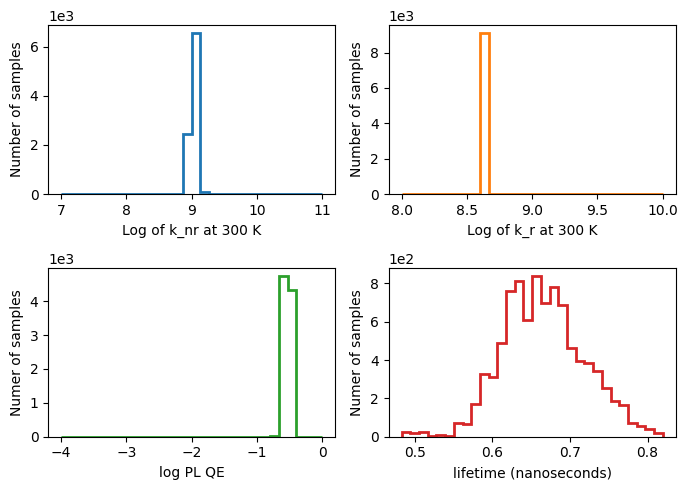

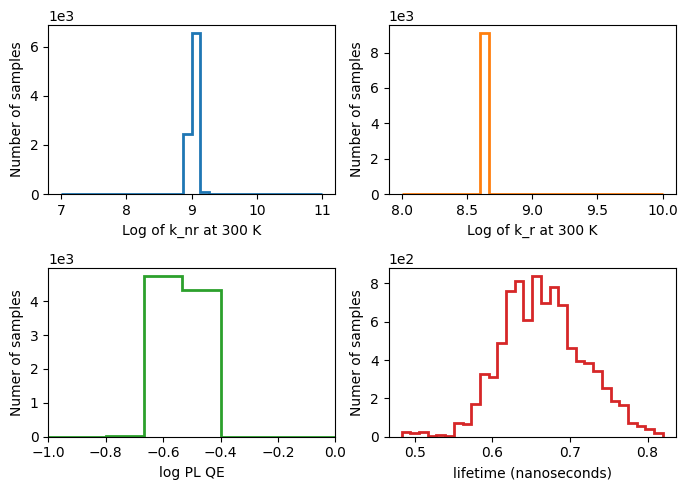

In [25]:
def plot_lifetime(
    reader,
    range_chi_square=(7, 11),
    range_log_prior=(7, 11),
    discard=5,
    temperature=300,
    filter_log_likelihood=False,
):
    """plot the lifetime distribution from the sampling output
    reader: the reader object from the emcee sampler
    range_chi_square: the range for the chi square plot
    range_log_prior: the range for the log prior plot
    discard: the number of samples to discard
    temperature: the temperature at which the lifetime is calculated
    """
    print("number of iterations", reader.iteration)
    blobs = reader.get_blobs(flat=True, discard=discard)
    if filter_log_likelihood:
        blobs = blobs[
            blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1
        ]
    fig, ax = plt.subplots(2, 2, figsize=(7, 5))

    ax = ax.flatten()
    ax[0].hist(
        np.log10(blobs["Ex_knr"]),
        30,
        histtype="step",
        range=range_chi_square,
        color="C" + str(0),
        linewidth=2,
    )
    ax[0].set_xlabel("Log of k_nr at " + str(temperature) + " K")
    ax[0].set_ylabel("Number of samples")
    ax[1].hist(
        np.log10(blobs["Ex_kr"]),
        30,
        histtype="step",
        range=range_log_prior,
        color="C" + str(1),
        linewidth=2,
    )
    ax[1].set_xlabel("Log of k_r at " + str(temperature) + " K")
    ax[1].set_ylabel("Number of samples")
    pl_QE = blobs["Ex_kr"] / (blobs["Ex_kr"] + blobs["Ex_knr"])
    ax[2].hist(
        np.log10(pl_QE),
        30,
        histtype="step",
        range=(-4, 0),
        color="C" + str(2),
        linewidth=2,
    )
    ax[2].set_xlabel("log PL QE")
    ax[2].set_ylabel("Numer of samples")
    lifetime = 1 / (blobs["Ex_kr"] + blobs["Ex_knr"])
    ax[3].hist(
        lifetime * 1e9,
        30,
        histtype="step",
        color="C" + str(3),
        linewidth=2,
    )
    ax[3].set_xlabel("lifetime (nanoseconds)")
    ax[3].set_ylabel("Numer of samples")
    # set y ticks to exponent form
    for i in range(4):
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    fig.tight_layout()
    plt.show()
    return fig, ax
fig, ax = plot_lifetime(reader, discard=100, filter_log_likelihood=True,range_log_prior=[8, 10])
ax[2].set_xlim(-1, 0)
fig

shape of mean value plot is (85, 7)


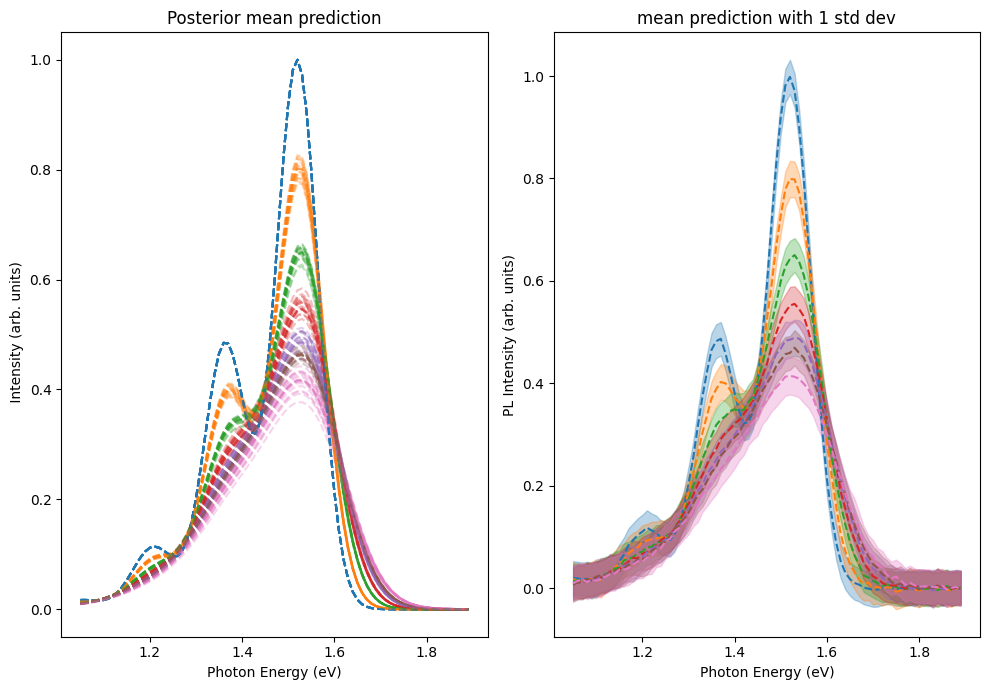

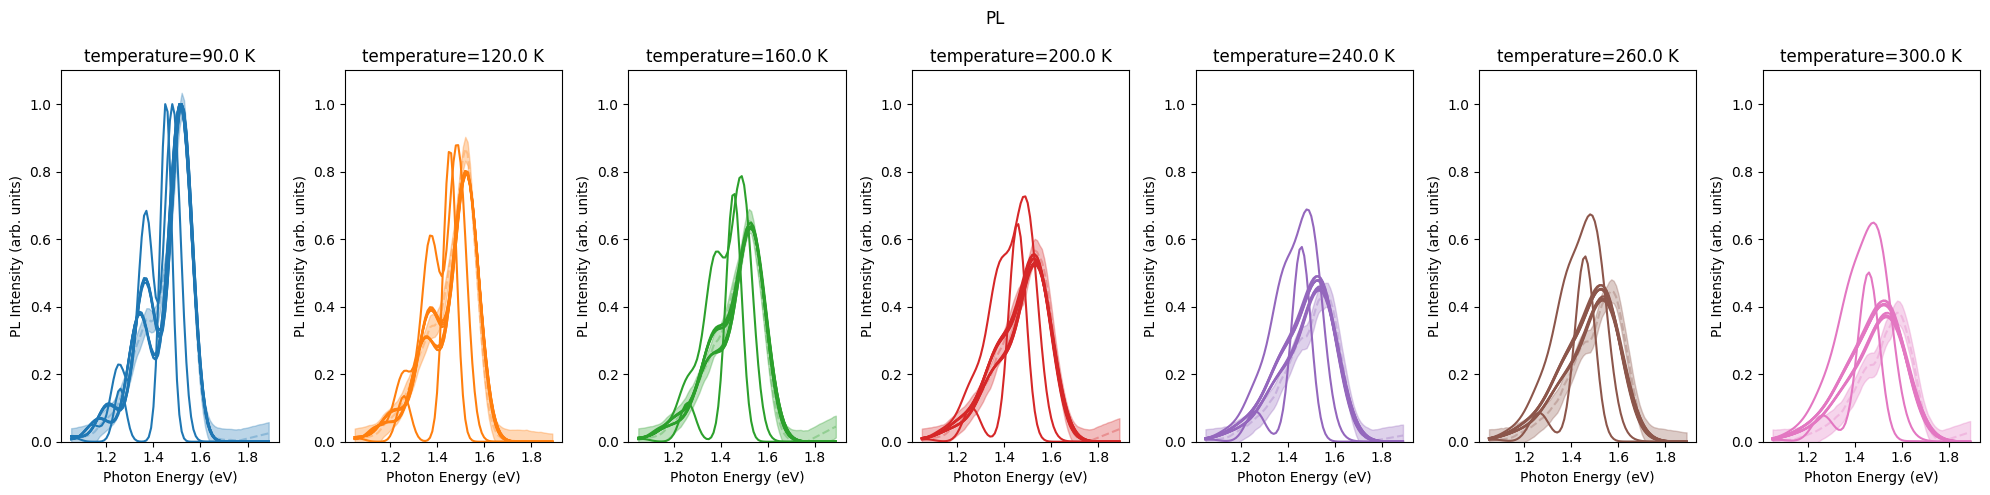

In [28]:
from pl_temp_fit import covariance_utils
def plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=10,
    chains_list=None,
    filter_log_likelihood=False,
):
    """plot the fit to the experimental data
    model_config_save: the model config save dictionary
    model_config: the model config dictionary
    reader: the reader object from the emcee sampler
    discard: the number of samples to discard
    chains_list: the list of chains to plot
    """
    Temp_std_err = model_config_save["Temp_std_err"]
    hws_std_err = model_config_save["hws_std_err"]
    relative_intensity_std_error_pl = model_config_save[
        "relative_intensity_std_error_pl"
    ]
    sigma = model_config_save["sigma"]
    save_folder = model_config_save["save_folder"]
    fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
    params_to_fit_init = model_config_save["params_to_fit_init"]
    min_bounds = model_config_save["min_bounds"]
    max_bounds = model_config_save["max_bounds"]
    csv_name = model_config_save["csv_name_pl"]
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
    distribution = reader.get_chain(discard=discard)
    if chains_list is not None:
        distribution = distribution[:, chains_list, :].reshape(
            -1, distribution.shape[-1]
        )
    else:
        distribution = distribution.reshape(-1, distribution.shape[-1])
        if filter_log_likelihood:
            blobs = reader.get_blobs(flat=True, discard=discard)
            distribution = distribution[
                blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 3
            ]
    true_parameters = fit_pl_utils.get_param_dict(
        params_to_fit_init, distribution[-1]
    )  # model_config_save['params_to_fit_init']#
    co_var_mat_pl, variance_pl = covariance_utils.plot_generated_data_pl(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
    fig, ax = fit_pl_utils.plot_exp_data_with_variance(
        temperature_list,
        hws,
        variance_pl,
        save_folder,
        fixed_parameters_dict,
        true_parameters,
        Exp_data,
    )
    for true_parameters in distribution[
        np.random.choice(len(distribution), 10), :
    ]:

        true_parameters = fit_pl_utils.get_param_dict(
            params_to_fit_init, true_parameters
        )

        fig, ax = fit_pl_utils.plot_exp_data_with_variance(
            temperature_list,
            hws,
            variance_pl,
            save_folder,
            fixed_parameters_dict,
            true_parameters,
            Exp_data,
            fig=fig,
            axis=ax,
        )

    # delete legend from ax
    for axis in ax:
        axis.get_legend().remove()
    return fig, ax
fig,ax = plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=50,
    filter_log_likelihood=True,
)